<a href="https://colab.research.google.com/github/Dkatya/Dkatya/blob/main/lobbying_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded: 32256 records, 25 columns
Date range: 2019 - 2025

Column names: ['Form Submission ID', 'Reporting Year', 'Filing Type', 'Reporting Period', 'Principal Lobbyist Name', 'Contractual Client Name', 'Beneficial Client Name', 'Co-Lobbyist', 'Sub-Lobbyist', 'Individual Lobbyists', 'Current Period Compensation', 'Current Period Reimbursement', 'DPM Expense Type', 'Expense paid to', 'Expense Amount', 'DPM Expense Purpose', 'DPM Expense Date', 'Type of Lobbying Relationship', 'Level of Government', 'Description of the DPM', 'Government Body', 'Parties Lobbied', 'First and Last Name OR Title of Person Lobbied', 'Unit, Division, Department or Social Media Platform Lobbied', 'Unique ID'] 

First 5 rows:
Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32256 entries, 0 to 32255
Data columns (total 25 columns):
 #   Column                                                       Non-Null Count  Dtype 
---  ------                                           

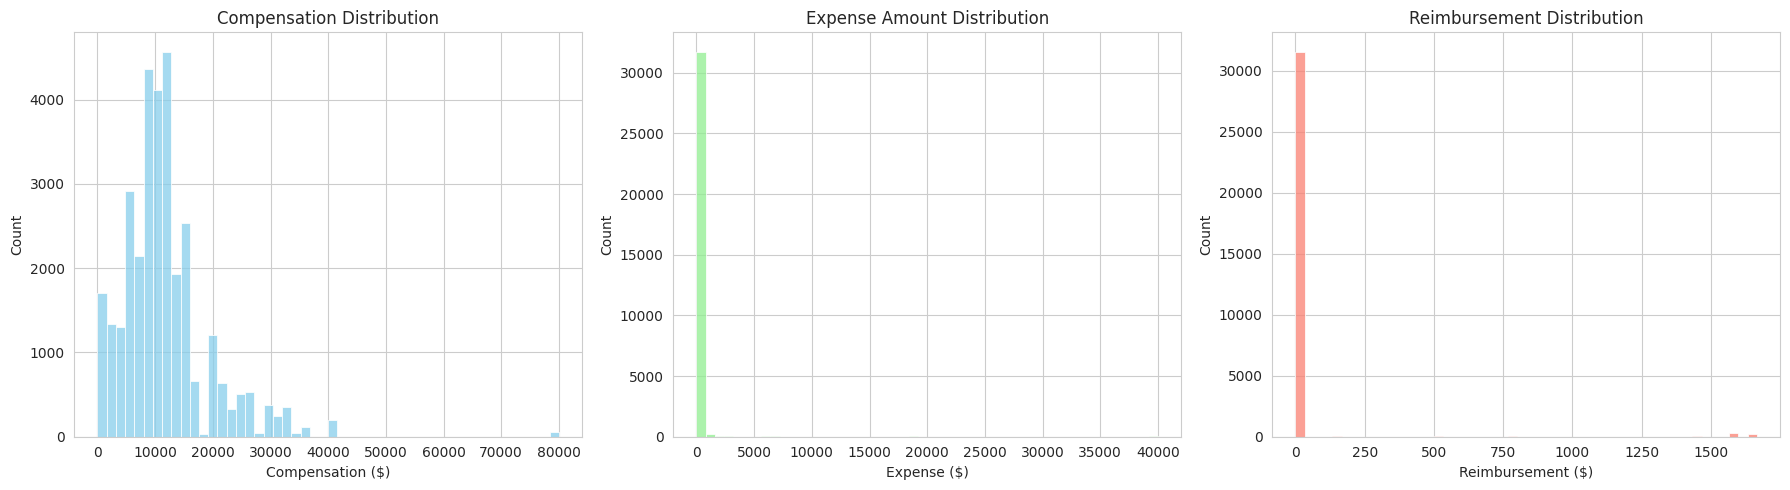

Missing descriptions: 0.51%



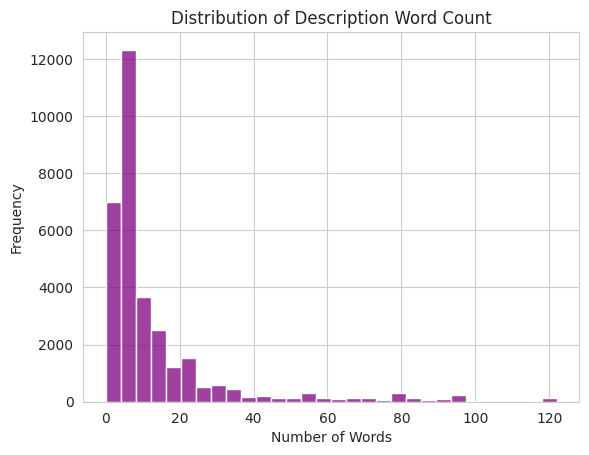

Top 10 lobbyists by total spending:
Principal Lobbyist Name
KASIRER LLC                                                        137836798.0
THE PARKSIDE GROUP LLC                                              57274900.0
PITTA BISHOP & DEL GIORNO LLC                                       52043144.0
INTERAGENCY COUNCIL OF DEVELOPMENTAL DISABILITIES AGENCIES, INC     45584005.0
LEADINGAGE NEW YORK                                                 33921186.0
James F. Capalino & Associates, Inc.                                26455822.0
CONSORTIUM FOR WORKER EDUCATION, INC.                                4461091.0
PRIMARY CARE DEVELOPMENT CORPORATION                                 4290226.0
CONVERGE GOVERNMENT AFFAIRS NEW YORK, LLC                            4083000.0
YOSWEIN NEW YORK, INC.                                               3732200.0
Name: total_spending, dtype: float64


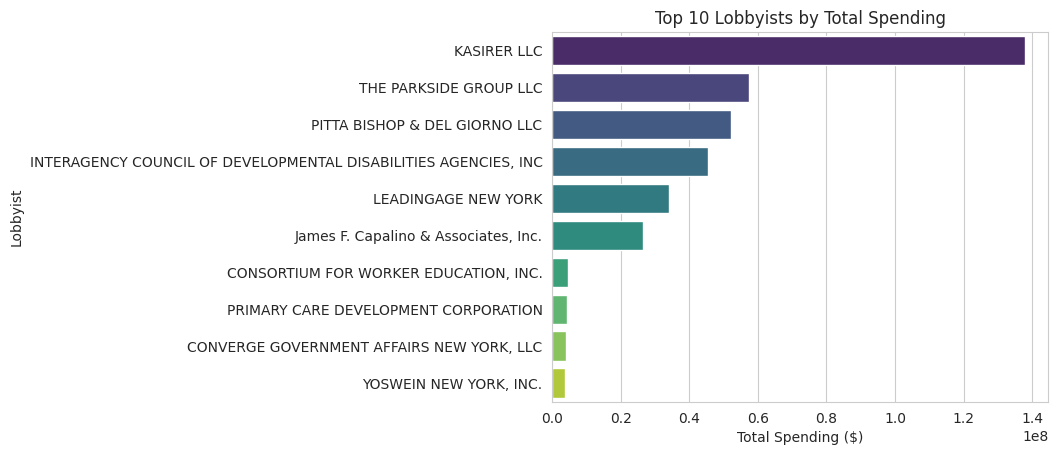

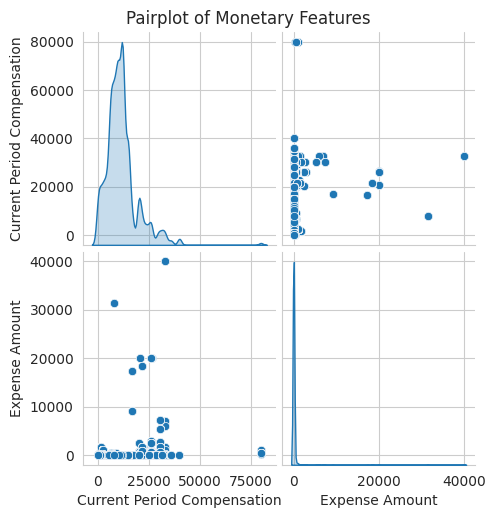

In [4]:
# ==============================
# Exploratory Data Analysis (EDA)
# ==============================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Load dataset
# ------------------------------
df = pd.read_csv(
    'dpm_data.csv',
    sep=',',
    engine='python',
    quoting=1,         # csv.QUOTE_MINIMAL, treats quotes properly
    escapechar='\\'    # handles escaped quotes
)

print(f"Dataset loaded: {len(df)} records, {df.shape[1]} columns")
print(f"Date range: {df['Reporting Year'].min()} - {df['Reporting Year'].max()}\n")


# ------------------------------
# 0.1 Inspect basic info
# ------------------------------
print("Column names:", df.columns.tolist(), "\n")
print("First 5 rows:")
df.head()

print("Data types and missing values:")
print(df.info(), "\n")
print("Number of missing values per column:")
print(df.isna().sum(), "\n")


# ------------------------------
# 2. Clean currency columns
# ------------------------------
def clean_currency(column):
    column = column.astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
    column = column.replace('nan', '0')
    return column.astype(float)

df['Current Period Compensation'] = clean_currency(df['Current Period Compensation'])
df['Current Period Reimbursement'] = clean_currency(df['Current Period Reimbursement'])
df['Expense Amount'] = clean_currency(df['Expense Amount'])

print(f"Total compensation: ${df['Current Period Compensation'].sum():,.2f}")
print(f"Total expenses: ${df['Expense Amount'].sum():,.2f}\n")

# ------------------------------
# 0.3 Summary statistics
# ------------------------------
print("Numeric summary statistics:")
print(df[['Current Period Compensation', 'Current Period Reimbursement', 'Expense Amount']].describe(), "\n")

# ------------------------------
# 0.4 Distribution plots
# ------------------------------
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['Current Period Compensation'], bins=50, ax=axes[0], color='skyblue')
axes[0].set_title('Compensation Distribution')
axes[0].set_xlabel('Compensation ($)')

sns.histplot(df['Expense Amount'], bins=50, ax=axes[1], color='lightgreen')
axes[1].set_title('Expense Amount Distribution')
axes[1].set_xlabel('Expense ($)')

sns.histplot(df['Current Period Reimbursement'], bins=50, ax=axes[2], color='salmon')
axes[2].set_title('Reimbursement Distribution')
axes[2].set_xlabel('Reimbursement ($)')

plt.tight_layout()
plt.show()

# ------------------------------
# 0.5 Check missing descriptions
# ------------------------------
if 'Description of the DPM' in df.columns:
    missing_desc_rate = df['Description of the DPM'].isna().mean()
    print(f"Missing descriptions: {missing_desc_rate*100:.2f}%\n")

    # Count number of words in each description
    df['desc_word_count'] = df['Description of the DPM'].fillna('').apply(lambda x: len(x.split()))
    sns.histplot(df['desc_word_count'], bins=30, color='purple')
    plt.title('Distribution of Description Word Count')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

# ------------------------------
# 0.6 Top lobbyists by spending
# ------------------------------
df['total_spending'] = df['Current Period Compensation'] + df['Expense Amount']
top_lobbyists = df.groupby('Principal Lobbyist Name')['total_spending'].sum().sort_values(ascending=False).head(10)
print("Top 10 lobbyists by total spending:")
print(top_lobbyists)

sns.barplot(x=top_lobbyists.values, y=top_lobbyists.index, palette='viridis')
plt.xlabel('Total Spending ($)')
plt.ylabel('Lobbyist')
plt.title('Top 10 Lobbyists by Total Spending')
plt.show()

# ------------------------------
# 0.7 Optional: Pairplot for numeric features
# ------------------------------
sns.pairplot(df[['Current Period Compensation', 'Expense Amount']], diag_kind='kde')
plt.suptitle('Pairplot of Monetary Features', y=1.02)
plt.show()


Aggregated 40 active lobbyists

Summary statistics:
       total_spending  compensation  total_expenses
count    4.000000e+01  4.000000e+01    4.000000e+01
mean     6.499244e+05  5.669547e+05    8.296975e+04
std      1.649414e+06  1.569371e+06    4.954764e+05
min      8.300000e+01  8.300000e+01    0.000000e+00
25%      4.628750e+03  3.040500e+03    0.000000e+00
50%      4.561000e+04  3.150100e+04    0.000000e+00
75%      1.030125e+05  1.030125e+05    0.000000e+00
max      8.955233e+06  8.955233e+06    3.136670e+06

Top 5 spenders:
  KASIRER LLC → $8,955,233
  INTERAGENCY COUNCIL OF DEVELOPMENTAL DISABILITIES  → $3,811,130
  PITTA BISHOP & DEL GIORNO LLC → $3,121,703
  James F. Capalino & Associates, Inc. → $2,754,661
  THE PARKSIDE GROUP LLC → $2,345,300

Running K-Means...
  Silhouette Score: 0.4367
  Davies-Bouldin Index: 0.7219
  Final Inertia (WCSS): 62.25
  Iterations to Converge (Best Run): 5
Detecting anomalies...
Found 4 anomalies (10.0%)

TOP 10 ANOMALOUS LOBBYISTS BY TOTAL SP

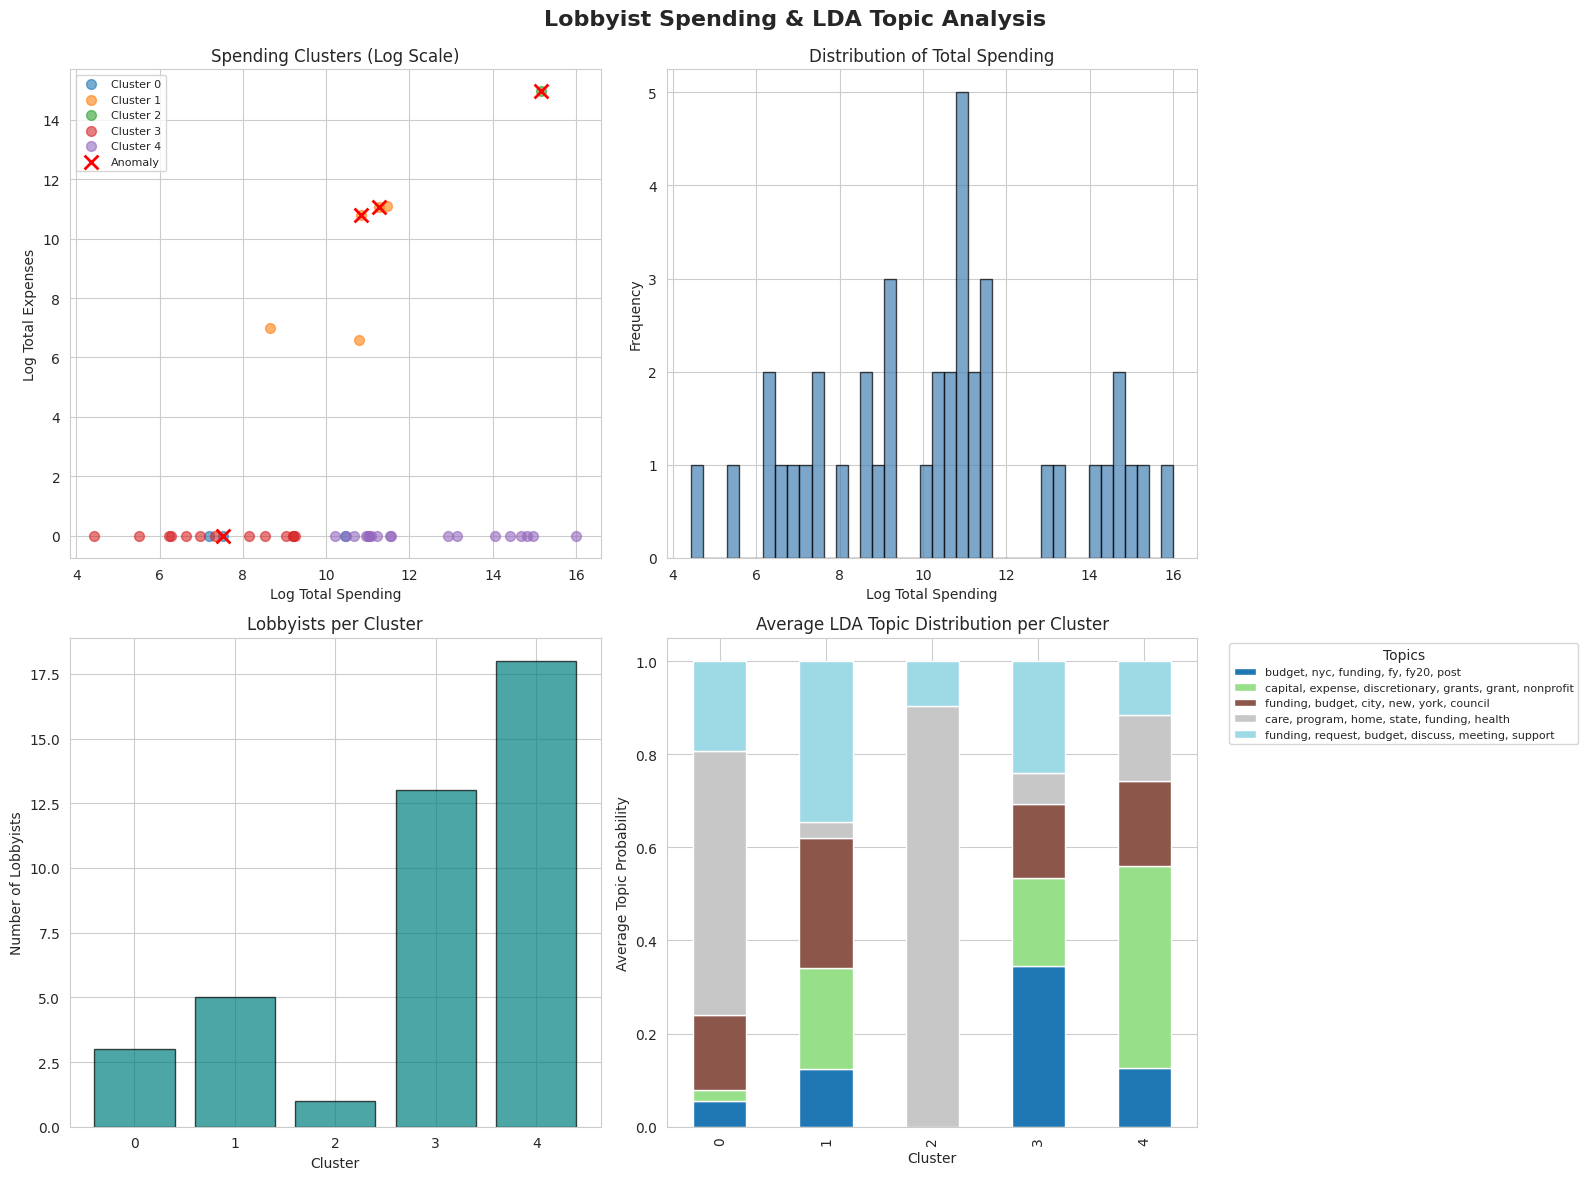

✓ Saved visualization to 'lobbyist_analysis_with_topics.png'


In [8]:


# ------------------------------
# 3. Aggregate financial data per lobbyist
# ------------------------------
# Compensation per lobbyist
submissions = df.drop_duplicates(subset='Form Submission ID').groupby('Principal Lobbyist Name').agg({
    'Current Period Compensation': 'sum',
    'Current Period Reimbursement': 'sum',
    'Form Submission ID': 'count'
}).reset_index().rename(columns={
    'Principal Lobbyist Name': 'lobbyist',
    'Current Period Compensation': 'compensation',
    'Current Period Reimbursement': 'reimbursement',
    'Form Submission ID': 'num_submissions'
})

# Expenses per lobbyist (exclude zero amounts)
expenses = df[df['Expense Amount'] > 0].groupby('Principal Lobbyist Name').agg({
    'Expense Amount': ['sum', 'mean', 'max', 'count']
}).reset_index()
expenses.columns = ['lobbyist', 'total_expenses', 'avg_expense', 'max_expense', 'num_expenses']

# Merge
grouped = submissions.merge(expenses, on='lobbyist', how='outer').fillna(0)

# Drop lobbyists with no financial activity if they exist
grouped = grouped[(grouped['compensation'] + grouped['total_expenses']) > 0]

print(f"Aggregated {len(grouped)} active lobbyists\n")

# ------------------------------
# 4. Create additional features
# ------------------------------
grouped['total_spending'] = grouped['compensation'] + grouped['total_expenses']
grouped['reimbursement_rate'] = grouped['reimbursement'] / (grouped['compensation'] + 0.01)
grouped['expense_per_submission'] = grouped['total_expenses'] / (grouped['num_submissions'] + 0.01)

#  missing description rate
if 'Description of the DPM' in df.columns:
    desc_stats = df.groupby('Principal Lobbyist Name').agg({
        'Description of the DPM': lambda x: x.isna().sum() / len(x)
    }).reset_index().rename(columns={'Principal Lobbyist Name': 'lobbyist', 'Description of the DPM': 'missing_desc_rate'})
    grouped = grouped.merge(desc_stats, on='lobbyist', how='left').fillna(0)

print("Summary statistics:")
print(grouped[['total_spending', 'compensation', 'total_expenses']].describe())
print("\nTop 5 spenders:")
for _, row in grouped.nlargest(5, 'total_spending').iterrows():
    print(f"  {row['lobbyist'][:50]} → ${row['total_spending']:,.0f}")
print()

# ------------------------------
# 5. Log transform to reduce skew
# ------------------------------
for col in ['total_spending', 'compensation', 'total_expenses', 'avg_expense', 'max_expense']:
    grouped[f'log_{col}'] = np.log1p(grouped[col])

# ------------------------------
# 6. Text-based features: LDA topics
# ------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Combine all descriptions per lobbyist
texts = df.groupby('Principal Lobbyist Name')['Description of the DPM'] \
          .apply(lambda x: ' '.join(x.dropna())).reset_index()

# Convert text to word counts (bag-of-words)
vectorizer = CountVectorizer(max_features=500, stop_words='english')
text_matrix = vectorizer.fit_transform(texts['Description of the DPM'])

# Fit LDA model
n_topics = 5  # adjust if you want more/fewer topics
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_matrix = lda.fit_transform(text_matrix)

# Create a DataFrame of topic probabilities
lda_df = pd.DataFrame(lda_matrix, columns=[f'topic_{i}' for i in range(n_topics)])
lda_df['lobbyist'] = texts['Principal Lobbyist Name']

# Merge LDA topics into grouped DataFrame
grouped = grouped.merge(lda_df, on='lobbyist', how='left').fillna(0)


# ------------------------------
# 6. Standardize features for clustering
# ------------------------------
features = ['log_total_spending', 'log_compensation', 'log_total_expenses',
            'log_avg_expense', 'log_max_expense', 'reimbursement_rate']

if 'missing_desc_rate' in grouped.columns:
    features.append('missing_desc_rate')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(grouped[features])

# Add LDA topic features
lda_features = [f'topic_{i}' for i in range(n_topics)]
features.extend(lda_features)

# ------------------------------
# 8. Cluster lobbyists
# ------------------------------
# ------------------------------------------------------
# 2. K-MEANS (BASELINE) with Convergence Check
# ------------------------------------------------------
print("Running K-Means...")
k = 5

# n_init=10 means it runs the algorithm 10 times and picks the best result (lowest WCSS)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_scaled)

grouped['cluster'] = kmeans.predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, grouped['cluster'])
db_kmeans = davies_bouldin_score(X_scaled, grouped['cluster'])

print(f"  Silhouette Score: {sil_kmeans:.4f}")
print(f"  Davies-Bouldin Index: {db_kmeans:.4f}")

# --- Convergence Output ---
# Inertia is the final Total Within-Cluster Sum of Squares (WCSS)
print(f"  Final Inertia (WCSS): {kmeans.inertia_:.2f}")
# n_iter_ tells you how many iterations the best run took to converge
print(f"  Iterations to Converge (Best Run): {kmeans.n_iter_}")


# ------------------------------
# 8. Anomaly detection
# ------------------------------
print("Detecting anomalies...")
iso = IsolationForest(contamination=0.1, random_state=42)
grouped['is_anomaly'] = iso.fit_predict(X_scaled) == -1

num_anomalies = grouped['is_anomaly'].sum()
print(f"Found {num_anomalies} anomalies ({num_anomalies/len(grouped)*100:.1f}%)\n")

# ------------------------------
# 9. Display summary
# ------------------------------
print("="*70)
print("TOP 10 ANOMALOUS LOBBYISTS BY TOTAL SPENDING")
print("="*70)
top_anomalies = grouped[grouped['is_anomaly']].sort_values(by='total_spending', ascending=False).head(10)
for i, row in top_anomalies.iterrows():
    print(f"{row['lobbyist'][:50]:<50} → ${row['total_spending']:>12,.0f} | Cluster {row['cluster']}")

print("\n" + "="*70)
print("NORMAL VS ANOMALY COMPARISON")
print("="*70)
normal = grouped[~grouped['is_anomaly']]
anomaly = grouped[grouped['is_anomaly']]

print(f"\nNormal lobbyists ({len(normal)}):")
print(f"  Avg spending: ${normal['total_spending'].mean():,.2f}")
print(f"  Median spending: ${normal['total_spending'].median():,.2f}")

print(f"\nAnomalous lobbyists ({len(anomaly)}):")
print(f"  Avg spending: ${anomaly['total_spending'].mean():,.2f}")
print(f"  Median spending: ${anomaly['total_spending'].median():,.2f}")

# ------------------------------
# 10. Visualizations with LDA topics
# ------------------------------
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Lobbyist Spending & LDA Topic Analysis', fontsize=16, fontweight='bold')

# ------------------------------
# 10a. Spending Clusters Scatter
# ------------------------------
ax1 = axes[0, 0]
for c in range(k):
    data = grouped[grouped['cluster'] == c]
    ax1.scatter(data['log_total_spending'], data['log_total_expenses'], alpha=0.6, s=50, label=f'Cluster {c}')
ax1.scatter(anomaly['log_total_spending'], anomaly['log_total_expenses'],
           color='red', marker='x', s=100, label='Anomaly', linewidths=2)
ax1.set_xlabel('Log Total Spending')
ax1.set_ylabel('Log Total Expenses')
ax1.set_title('Spending Clusters (Log Scale)')
ax1.legend(fontsize=8)

# ------------------------------
# 10b. Spending Histogram
# ------------------------------
ax2 = axes[0, 1]
ax2.hist(grouped['log_total_spending'], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Log Total Spending')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Total Spending')

# ------------------------------
# 10c. Lobbyists per Cluster
# ------------------------------
ax3 = axes[1, 0]
counts = grouped['cluster'].value_counts().sort_index()
ax3.bar(counts.index, counts.values, color='teal', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Number of Lobbyists')
ax3.set_title('Lobbyists per Cluster')

# ------------------------------
# 10d. Average LDA Topic Distribution per Cluster
# ------------------------------
# Prepare topic columns
topic_cols = [f'topic_{i}' for i in range(n_topics)]

# Extract top words per topic for labels
n_top_words = 6
feature_names = vectorizer.get_feature_names_out()
topic_labels = []
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    label = ", ".join(top_words)
    topic_labels.append(label)

# Compute cluster-level averages for each topic
cluster_topics = grouped.groupby('cluster')[topic_cols].mean()

# Plot stacked bar chart
ax4 = axes[1, 1]
cluster_topics.plot(kind='bar', stacked=True, ax=ax4, colormap='tab20')
ax4.set_title('Average LDA Topic Distribution per Cluster')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Average Topic Probability')
ax4.legend(title='Topics', labels=topic_labels, bbox_to_anchor=(1.05, 1), fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # adjust to fit title
plt.savefig('lobbyist_analysis_with_topics.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved visualization to 'lobbyist_analysis_with_topics.png'")





Preparing features...
Using features:
  - log_total_spending
  - log_compensation
  - log_total_expenses
  - log_avg_expense
  - log_max_expense
  - reimbursement_rate

Dataset ready: 37 lobbyists, 6 features

Running K-Means...
  Silhouette Score: 0.5146
  Davies-Bouldin Index: 0.4993

Running DBSCAN grid search...
  eps=0.5: clusters=3, noise=9, silhouette=0.6559
  eps=0.8: insufficient clusters
  eps=1.0: insufficient clusters
  eps=1.5: insufficient clusters

Best eps: 0.5 with silhouette=0.6559

DBSCAN results:
  Clusters: 3
  Noise points: 9
  Silhouette Score: 0.6559

Running custom K-Medoids...
  Silhouette Score: 0.4717
  Davies-Bouldin: 1.1663

Medoid representatives:
  Cluster 0: SUNY COLLEGE OF ENVIRONMENTAL SCIENCE AND FORESTRY
  Cluster 1: THE VANDERVORT GROUP, LLC
  Cluster 2: CONVERGE GOVERNMENT AFFAIRS NEW YORK, LLC
  Cluster 3: ASIAN AMERICAN COALITION FOR CHILDREN AND FAMILIES, INC.
  Cluster 4: William A. Schnell & Associates, Inc.

MODEL COMPARISON SUMMARY
       

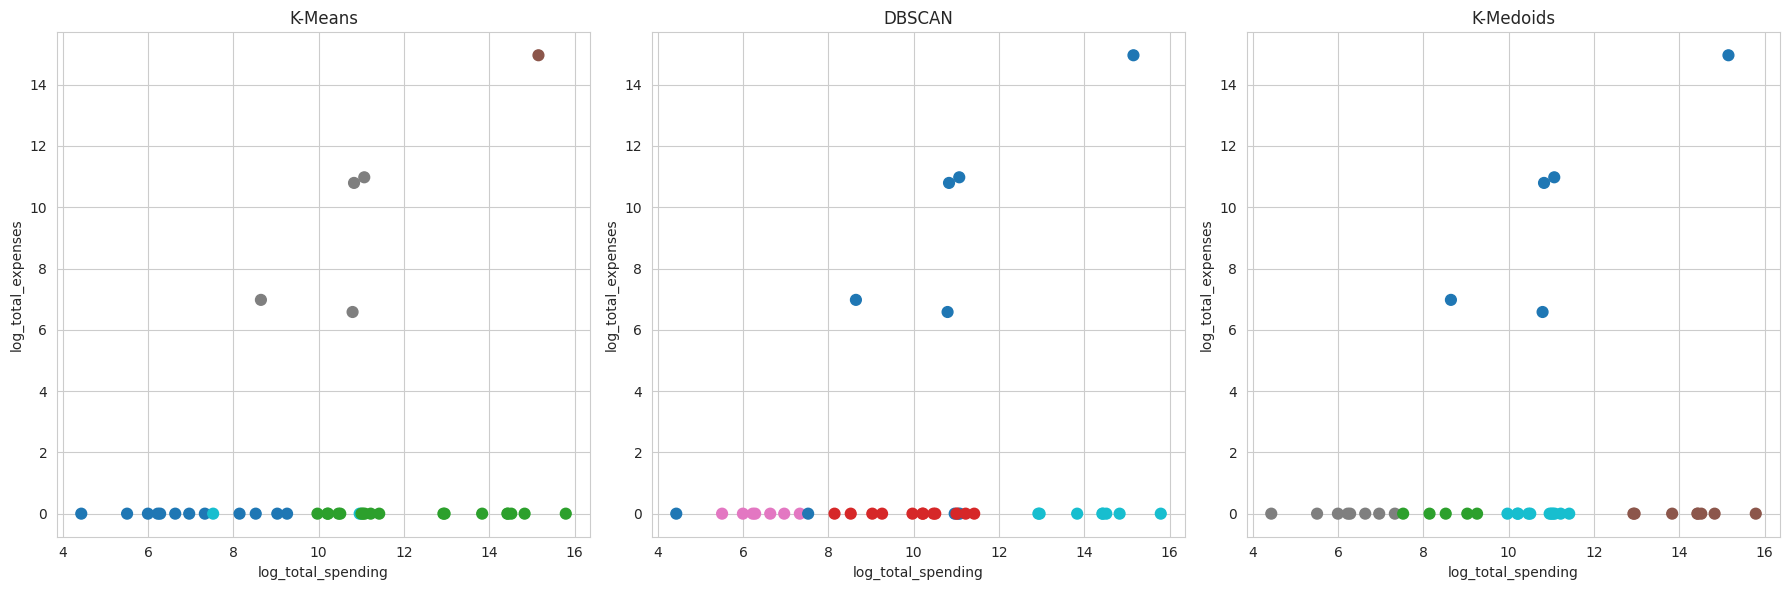


DBSCAN ANOMALIES

Total anomalies: 9
                                             lobbyist  total_spending
1                      APICHA COMMUNITY HEALTH CENTER         50402.0
12                           CSX TRANSPORTATION, INC.         48720.0
14                         HARTER SECREST & EMERY LLP         57545.0
15                        HARTER SECREST & EMERY, LLP         64815.0
16  INTERAGENCY COUNCIL OF DEVELOPMENTAL DISABILIT...       3811130.0
17                                 JACKSON LEWIS P.C.          1851.0
22                                NEW YORK EDGE, INC.          5676.0
24                         PRESERVATION LEAGUE OF NYS            83.0
27  SUNY COLLEGE OF ENVIRONMENTAL SCIENCE AND FORE...         64075.0


In [6]:
# =============================================
# CLUSTERING COMPARISON: K-Means, DBSCAN, K-Medoids
# =============================================
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------
# 1. SELECT FEATURES FOR CLUSTERING
# ------------------------------------------------------
print("\nPreparing features...")

features = [
    'log_total_spending',
    'log_compensation',
    'log_total_expenses',
    'log_avg_expense',
    'log_max_expense',
    'reimbursement_rate'
]

print("Using features:")
for f in features:
    print("  -", f)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(grouped[features])

print(f"\nDataset ready: {X_scaled.shape[0]} lobbyists, {X_scaled.shape[1]} features")
print("="*70, "\n")

# ------------------------------------------------------
# 2. K-MEANS (BASELINE)
# ------------------------------------------------------
print("Running K-Means...")
k = 5

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
grouped['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, grouped['cluster_kmeans'])
db_kmeans = davies_bouldin_score(X_scaled, grouped['cluster_kmeans'])

print(f"  Silhouette Score: {sil_kmeans:.4f}")
print(f"  Davies-Bouldin Index: {db_kmeans:.4f}")

# ------------------------------------------------------
# 3. DBSCAN (DENSITY-BASED)
# ------------------------------------------------------
print("\n" + "="*70)
print("Running DBSCAN grid search...")

eps_values = [0.5, 0.8, 1.0, 1.5]
best_eps = None
best_sil = -2

for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=5)
    labels = model.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    if n_clusters > 1:
        score = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
        print(f"  eps={eps}: clusters={n_clusters}, noise={n_noise}, silhouette={score:.4f}")
        if score > best_sil:
            best_sil = score
            best_eps = eps
    else:
        print(f"  eps={eps}: insufficient clusters")

print(f"\nBest eps: {best_eps} with silhouette={best_sil:.4f}")

dbscan = DBSCAN(eps=best_eps, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)
grouped['cluster_dbscan'] = db_labels

n_clusters_dbscan = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_dbscan = list(db_labels).count(-1)

if n_clusters_dbscan > 1:
    sil_dbscan = silhouette_score(X_scaled[db_labels != -1], db_labels[db_labels != -1])
    db_dbscan = davies_bouldin_score(X_scaled[db_labels != -1], db_labels[db_labels != -1])
else:
    sil_dbscan = -1
    db_dbscan = np.nan

print(f"\nDBSCAN results:")
print(f"  Clusters: {n_clusters_dbscan}")
print(f"  Noise points: {n_noise_dbscan}")
print(f"  Silhouette Score: {sil_dbscan:.4f}")

# ------------------------------------------------------
# 4. CUSTOM K-MEDOIDS (NO sklearn_extra)
# ------------------------------------------------------
print("\n" + "="*70)
print("Running custom K-Medoids...")

def kmedoids(X, k, max_iter=300, random_state=42):
    np.random.seed(random_state)

    # Step 1: Initialize random medoids
    medoid_ids = np.random.choice(len(X), k, replace=False)

    for _ in range(max_iter):
        distances = np.array([[np.linalg.norm(X[i]-X[m]) for m in medoid_ids]
                              for i in range(len(X))])
        labels = distances.argmin(axis=1)

        new_medoids = []
        for cluster_id in range(k):
            cluster_points = np.where(labels == cluster_id)[0]
            if len(cluster_points) == 0:
                new_medoids.append(medoid_ids[cluster_id])
                continue

            intra_distances = np.sum(
                [np.linalg.norm(X[p] - X[cluster_points], axis=1)
                 for p in cluster_points],
                axis=1
            )
            new_medoids.append(cluster_points[np.argmin(intra_distances)])

        if np.array_equal(medoid_ids, new_medoids):
            break
        medoid_ids = new_medoids

    return np.array(medoid_ids), labels

medoid_ids, labels_kmed = kmedoids(X_scaled, k=5)
grouped['cluster_kmedoids'] = labels_kmed

sil_kmedoids = silhouette_score(X_scaled, labels_kmed)
db_kmedoids = davies_bouldin_score(X_scaled, labels_kmed)

print(f"  Silhouette Score: {sil_kmedoids:.4f}")
print(f"  Davies-Bouldin: {db_kmedoids:.4f}")
print("\nMedoid representatives:")
for c in range(k):
    idx = medoid_ids[c]
    print(f"  Cluster {c}: {grouped.iloc[idx]['lobbyist']}")

# ------------------------------------------------------
# 5. MODEL COMPARISON TABLE
# ------------------------------------------------------
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

summary = pd.DataFrame({
    "Model": ["K-Means", "DBSCAN", "K-Medoids"],
    "Silhouette": [sil_kmeans, sil_dbscan, sil_kmedoids],
    "DB Index": [db_kmeans, db_dbscan, db_kmedoids],
    "Clusters": [k, n_clusters_dbscan, k],
    "Outliers": [0, n_noise_dbscan, 0]
})

print(summary)

# ------------------------------------------------------
# 6. VISUALIZATION
# ------------------------------------------------------
print("\nGenerating visualization...")

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = [
    ('cluster_kmeans', "K-Means"),
    ('cluster_dbscan', "DBSCAN"),
    ('cluster_kmedoids', "K-Medoids")
]

for ax, (col, title) in zip(axes, models):
    scatter = ax.scatter(
        grouped['log_total_spending'],
        grouped['log_total_expenses'],
        c=grouped[col],
        cmap='tab10',
        s=60
    )
    ax.set_title(title)
    ax.set_xlabel("log_total_spending")
    ax.set_ylabel("log_total_expenses")

plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 7. DBSCAN ANOMALY REPORT
# ------------------------------------------------------
print("\n" + "="*70)
print("DBSCAN ANOMALIES\n")

grouped['is_dbscan_anomaly'] = grouped['cluster_dbscan'] == -1
anomalies = grouped[grouped['is_dbscan_anomaly']]

print(f"Total anomalies: {len(anomalies)}")
print(anomalies[['lobbyist', 'total_spending']].head(10))
